# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files 

**Date**: October 10th 2025

**Student Name**: Sergio Villa Rodríguez

**Professor**: Pablo Camarillo Ramirez

# Create Spark session

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://f0e377311925:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/11 03:13:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Create datastream from a directory

## Count the type of logs

In [ ]:
# Create the remote connection
logs = spark.readStream \
    .format("text") \
    .option("path", "/opt/spark/work-dir/data/lab07_logs/logs") \
    .load()
# Perform some transformations
# log_exapmle = 2025-10-09 14:23:51 [INFO] User logged in
from pyspark.sql.functions import explode, split, col
# Separa en dos parte tomando como referencia el primer espacio que encuentra
logs_t1 = logs.withColumn("parts", split(col("value"), " ", 3))
# Crea la columna date y time en donde se guardan esas partes del log, el resto se va a la columna log_content
logs_t2 = logs_t1.withColumn("date", col("parts").getItem(0)) \
                    .withColumn("time", col("parts").getItem(1)) \
                    .withColumn("log_content", col("parts").getItem(2))
# Parte en dos columnas el log content donde la primera contiene el tipo de log y la segunda el mensaje
logs_t3 = logs_t2.withColumn("log_type", split(col("log_content"), " ", 2).getItem(0)) \
                    .withColumn("log_message", split(col("log_content"), " ").getItem(1))
# Cuenta cuántos logs hay de cada tipo
logs_t4 = logs_t3.groupBy("log_type").count()

query = logs_t4.writeStream \
            .outputMode("complete") \
            .format("console") \
            .start()
query.awaitTermination(300)

-------------------------------------------
Batch: 0
-------------------------------------------
+--------+-----+
|log_type|count|
+--------+-----+
|  [WARN]|   11|
|  [INFO]|    6|
| [ERROR]|    8|
| [DEBUG]|    9|
+--------+-----+



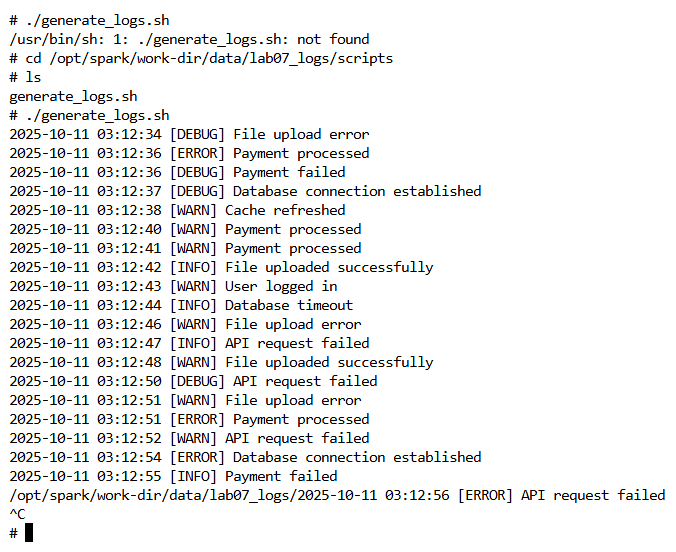

In [ ]:
sc.stop()